In [1]:
import pandas as pd
import numpy as np
import functools
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import datetime
import seaborn as sns
from sklearn.metrics import roc_curve, auc,roc_auc_score, accuracy_score
import matplotlib.pyplot as plt

#### Part 1  - Exploratory Data Analysis

In [2]:
logins_data = "./datasets/ultimate_challenge/logins.json"
logins_df = pd.read_json(logins_data)
logins_df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [3]:
# check for nulls
logins_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


In [4]:
# check for duplicates
logins_df.describe()

,login_time
count,93142
unique,92265
top,1970-02-12 11:16:53
freq,3
first,1970-01-01 20:12:16
last,1970-04-13 18:57:38


In [5]:
# Remove duplicates
logins_df.drop_duplicates(subset ="login_time",
                     keep = False, inplace = True)
logins_df.describe()

,login_time
count,91397
unique,91397
top,1970-03-19 13:50:20
freq,1
first,1970-01-01 20:12:16
last,1970-04-13 18:57:38


In [6]:
logins_df['login_time_rounded'] = (logins_df['login_time'] - pd.Timedelta('15min')).dt.round('15min') + pd.Timedelta('15min')
logins_df.head()

,login_time,login_time_rounded
0,1970-01-01 20:13:18,1970-01-01 20:15:00
1,1970-01-01 20:16:10,1970-01-01 20:15:00
2,1970-01-01 20:16:37,1970-01-01 20:15:00
3,1970-01-01 20:16:36,1970-01-01 20:15:00
4,1970-01-01 20:26:21,1970-01-01 20:30:00


In [7]:
logins_15Min_df = pd.DataFrame(logins_df['login_time_rounded'])

In [8]:
logins_15Min_df.head(10)

,login_time_rounded
0,1970-01-01 20:15:00
1,1970-01-01 20:15:00
2,1970-01-01 20:15:00
3,1970-01-01 20:15:00
4,1970-01-01 20:30:00
5,1970-01-01 20:15:00
6,1970-01-01 20:15:00
7,1970-01-01 20:30:00
8,1970-01-01 20:30:00
9,1970-01-01 20:45:00


In [9]:
logins_15Min_df = pd.DataFrame(logins_15Min_df.groupby(['login_time_rounded'])['login_time_rounded'].count())

In [10]:
logins_15Min_df.rename(columns={'login_time_rounded': 'login_count'}, inplace=True)
logins_15Min_df = logins_15Min_df.reset_index()

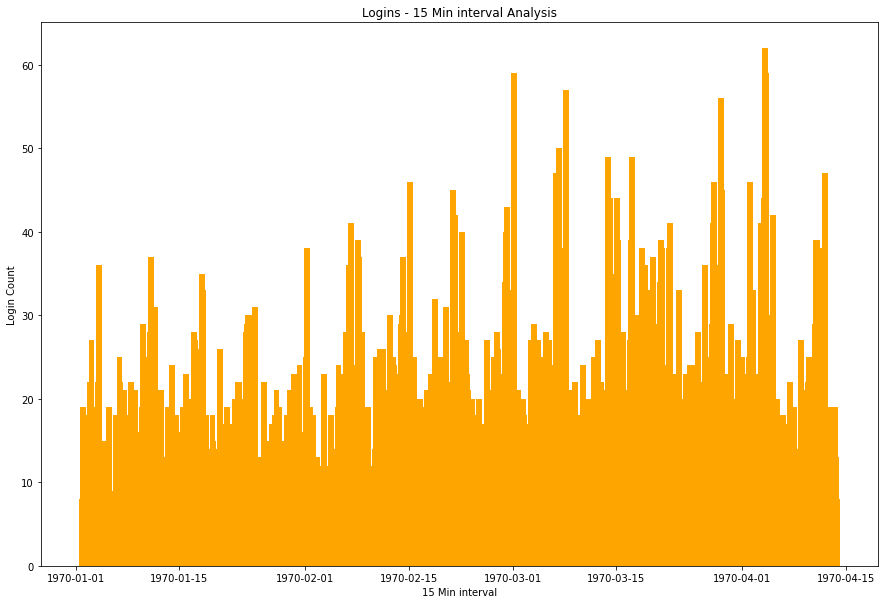

In [11]:
plt.figure(figsize=(15, 10))
plt.bar(logins_15Min_df['login_time_rounded'], logins_15Min_df['login_count'], color="orange")
plt.title('Logins - 15 Min interval Analysis')
plt.xlabel('15 Min interval')
plt.ylabel('Login Count')
plt.show()


### Feature Engineering

The above chart doesn't provide any detail trend; so let us do some feature engineering to derive 
meaningful features using the existing feature

In [12]:
logins_df['login_time'] = logins_df['login_time'].astype(str)

logins_df['ldate']=logins_df.apply(lambda x: x.login_time.split(' ')[0],axis=1)
logins_df['ltime']=logins_df.apply(lambda x: x.login_time.split(' ')[1],axis=1)

logins_df['year']=logins_df.apply(lambda x: x.ldate.split('-')[0],axis=1).astype(int)
logins_df['month']=logins_df.apply(lambda x: x.ldate.split('-')[1],axis=1).astype(int)
logins_df['day']=logins_df.apply(lambda x: x.ldate.split('-')[2],axis=1).astype(int)

logins_df['hour']=logins_df.apply(lambda x: x.ltime.split(':')[0],axis=1).astype(int)
logins_df['minute']=logins_df.apply(lambda x: x.ltime.split(':')[1],axis=1).astype(int)
logins_df['second']=logins_df.apply(lambda x: x.ltime.split(':')[2],axis=1).astype(int)

logins_df.head()

,login_time,login_time_rounded,ldate,ltime,year,month,day,hour,minute,second
0,1970-01-01 20:13:18,1970-01-01 20:15:00,1970-01-01,20:13:18,1970,1,1,20,13,18
1,1970-01-01 20:16:10,1970-01-01 20:15:00,1970-01-01,20:16:10,1970,1,1,20,16,10
2,1970-01-01 20:16:37,1970-01-01 20:15:00,1970-01-01,20:16:37,1970,1,1,20,16,37
3,1970-01-01 20:16:36,1970-01-01 20:15:00,1970-01-01,20:16:36,1970,1,1,20,16,36
4,1970-01-01 20:26:21,1970-01-01 20:30:00,1970-01-01,20:26:21,1970,1,1,20,26,21


In [13]:
# To understand the data availability range
def find_range(login_time_factor):
    return (min(login_time_factor),max(login_time_factor))


login_cols=['year','month','day','hour','minute','second']

for col in login_cols:
    print(col,find_range(logins_df[col]))

year (1970, 1970)
month (1, 4)
day (1, 31)
hour (0, 23)
minute (0, 59)
second (0, 59)


### Insights
1. Data is present for the year 1970
2. Data is present only for first four months of 1970

### Logins - Monthly Analysis

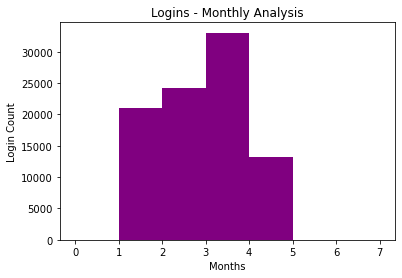

In [14]:
# Monthly Login Analysis - To identify the monthly trend

plt.hist(logins_df.month,bins=range(8), color='purple')
plt.title('Logins - Monthly Analysis')
plt.xlabel('Months')
plt.ylabel('Login Count')
plt.show()


1. Looks like March month had more logins.
2. Let's quickly check the login count is accurate by checking the data is present for all days in four months as April shows drastic decrease in the count from its previous month high count

In [15]:
days = []
for month in sorted(logins_df['month'].unique()):
    days_ = sorted(set(logins_df.day[logins_df.month==month]))
    print(f'Days in Month# {month}: {days_}')
    

Days in Month# 1: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
Days in Month# 2: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]
Days in Month# 3: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
Days in Month# 4: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]


The above day wise login data shows that April has partial data that is until 13th only. 

### 15 Min Interval Logins - Analysis

For analysis purpose, let us mark 0min ->0, 15min->1, 30min->2, 45min->3

In [16]:
logins_df['15_min']=(logins_df.minute/15).apply(int)
logins_df['Mon_day_hr_15min']=list(zip(logins_df.month,logins_df.day,logins_df.hour,logins_df["15_min"]))


In [17]:
interval_15min = logins_df.pivot_table(index=['Mon_day_hr_15min'],values='day',aggfunc='count')
interval_15min.reset_index(drop=False,inplace=True)
interval_15min['Mon_day_hr_15min_ticks']=interval_15min.apply(lambda tick: functools.reduce(lambda a,b: str(a)+' '+ str(b),tick.Mon_day_hr_15min),axis=1)

In [18]:
interval_15min.head()

,Mon_day_hr_15min,day,Mon_day_hr_15min_ticks
0,"(1, 1, 20, 0)",2,1 1 20 0
1,"(1, 1, 20, 1)",6,1 1 20 1
2,"(1, 1, 20, 2)",9,1 1 20 2
3,"(1, 1, 20, 3)",7,1 1 20 3
4,"(1, 1, 21, 0)",1,1 1 21 0


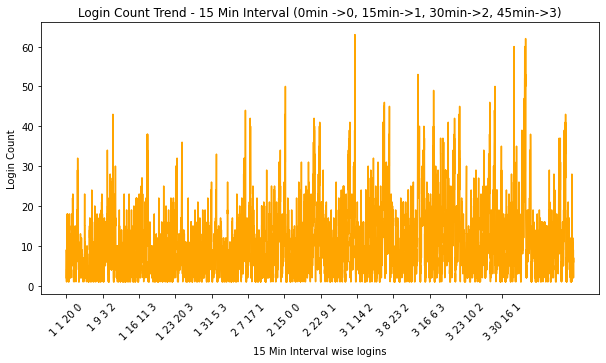

In [19]:
plt.figure(figsize=(10,5))
plt.plot(interval_15min.day, color="orange")
total_hrs=7*24*4
plt.xticks([x*total_hrs for x in range(int(len(interval_15min.day)/total_hrs))],[interval_15min.Mon_day_hr_15min_ticks[x*total_hrs] for x in range(int(len(interval_15min.Mon_day_hr_15min_ticks)/total_hrs))],rotation=45)
plt.title('Login Count Trend - 15 Min Interval (0min ->0, 15min->1, 30min->2, 45min->3)')
plt.xlabel('15 Min Interval wise logins')
plt.ylabel('Login Count')
plt.show()

### Logins - Hourly Average Analysis

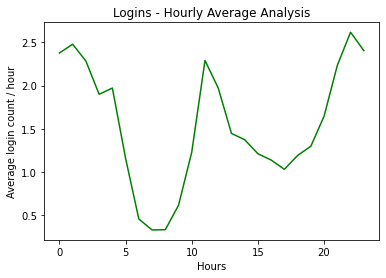

In [20]:
hours=logins_df.pivot_table(index='hour',values='minute',aggfunc='count')
login_available_days=31+28+31+13
login_available_hours=login_available_days*24
plt.plot(hours/login_available_hours, color='green')
plt.title('Logins - Hourly Average Analysis')
plt.ylabel('Average login count / hour')
plt.xlabel('Hours')
plt.show()



As we analyzed for 15 min interval and hourly, let us also analyze at the daily level to get weekday/weekend insights

### Logins - Daily (week days) Average Analysis

In [21]:
weekdays=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
logins_df['Weekday']=logins_df.apply(lambda x: datetime.date(x.year,x.month,x.day).strftime("%A"),axis=1)

In [22]:
week_daily_logins_temp=logins_df.pivot_table(index='ldate',columns='Weekday',values='ltime',aggfunc='count')
week_daily_logins=pd.DataFrame()
for day in weekdays:
    week_daily_logins[day]=week_daily_logins_temp[day]

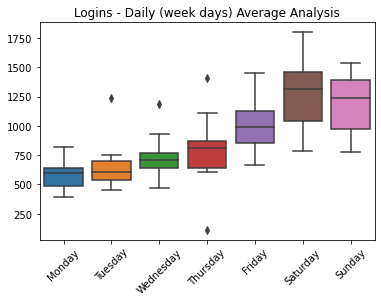

In [23]:
sns.boxplot(data=week_daily_logins)

plt.xticks(rotation=45)
plt.title('Logins - Daily (week days) Average Analysis')
plt.show()

#### Part 1 Analysis Outcome
1. The active logins start early morning on Monday and gradually moves towards 10 AM over the weekend.
2. The average number logins seems to be almost same for first three days of the week and gradually increase towards the weekend where Saturday and Sunday (weekends) contribute the most logins.
3. The analysis shows that holiday (weekend) logins outweighs the office hours (weekday) logins which shows recreational activities contribute for more business. 

### Part 2 - Experiment and metrics design

1) In the experiment proposal of reimbursing all toll costs, it is critical to note an important point in the description that Ultimate Gotham and Ultimate Metroplis have active night and day logins respectively but weekends have reasonalable activities in both the cities.

2) Also the part 1 exploratory analysis shows that the active logins during the week days (Monday to Friday) mostly occur during the office hours and whatever logins during the evenings are very less and should be considered as outliers to get clear picture.

3) As the part 1 exploratory analysis also showed weekend logins contributed more to the business, it is essential to measure the proposed experiment increases the weekday logins as well which would be the 'real' improvement in the business.

4) While we talked about weekday/weekend login trends, it is important to undertsand the customers who would be the ultimate factor to analyse the outcome of proposed experiment. Here we can try to categorize the customers who travel within home city, who travel completely in the ither city and who cross the bridge.

5) From testing perspective, the proposed experiment can be implemented on partial drivers and compare the outcomes with the outcome of drivers without the toll fee reimbursement which is something like comparing a controlled version with variable/test version. In machine learning terms, it is called A/B testing approach to measure the success rate.

6) When choosing the drivers to perform the above explained A/B testing strategy, it is better to pick the drivers share the charatecterics among the other drivers which would help us to avoid bias towards particular driver types.

7) Once the drivers are choosen as per above, among them, we can randomly select the equal number of drivers from the both the cities for the A/B testing. It is essential to make sure the drivers are from both the cities equally so that toll usage can be checked from both the directions. 

8) Also, instead of having overall single control group and variable group comprising both the city drivers, we can have a seperate control and variable group of drivers for each city to measure the scussess rate for both the city ies specifically.

9) The above approaches can also performed categoricaly with respect to weekdays and weekends to see the usccess rate from different perspective as we had observed weekends have more active logins w.r.t. our part 1 analysis.

10) The success rate or the outcome of the expermient can be evaluated by looking the below metrics:
    a) The home side drivers should see incresed rides to the other city among the variable group drivers.
    b) The increase in cross trips frequency among the variable group dirvers.
    c) The variable group drivers should also see overall increase in the rides as the external city trips would also 
    help them get more local rides on the external city which means the engagement rate of the driver should increase.



### Part 3 - Predictive modeling

In [24]:
ultimate_data = "./datasets/ultimate_challenge/ultimate_data_challenge.json"
ultimate_data_df = pd.read_json(ultimate_data)
ultimate_data_df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [25]:
ultimate_data_df.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,49799.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158
std,3.792684,0.617338,0.222336,19.958811,37.081503,5.707357,0.446652
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000


#### Null Analysis

In [26]:
# Null analysis
ultimate_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


There are three fields with null values.
1) avg_rating_of_driver
2) phone
3) avg_rating_by_driver

Let us try to address null values on these columns.

#### Handling Nulls in 'avg_rating_of_driver' field

<function matplotlib.pyplot.show(*args, **kw)>

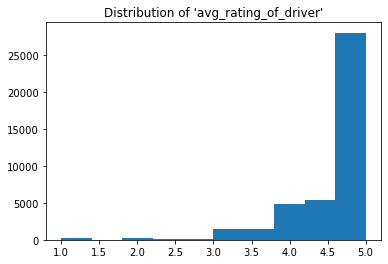

In [27]:
plt.hist(ultimate_data_df[np.logical_not(ultimate_data_df['avg_rating_of_driver'].isnull())]['avg_rating_of_driver'])
plt.title("Distribution of 'avg_rating_of_driver'")
plt.show

From the above histogram, it looks like most of the drivers have 4.5 to 5 range ratings. So we could think of assigning 4.5 to the missing values of avg_rating_by_driver field, but it is always safe to assign the mean value to avoid inject bias.

In [28]:
ultimate_data_df['avg_rating_of_driver'].fillna(ultimate_data_df['avg_rating_of_driver'].mean(), inplace=True)

#### Handling Nulls in 'avg_rating_by_driver' field

<function matplotlib.pyplot.show(*args, **kw)>

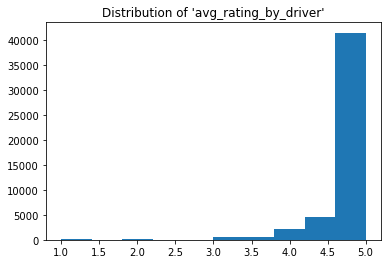

In [29]:
plt.hist(ultimate_data_df[np.logical_not(ultimate_data_df['avg_rating_by_driver'].isnull())]['avg_rating_by_driver'])
plt.title("Distribution of 'avg_rating_by_driver'")
plt.show

From the above histogram, it looks like most of the drivers have 4.5 to 5 range ratings for avg_rating_by_driver as well. So we can go with similar mean approach.

In [30]:
ultimate_data_df['avg_rating_by_driver'].fillna(ultimate_data_df['avg_rating_by_driver'].mean(), inplace=True)

#### Handling Nulls in 'Phone' field

<function matplotlib.pyplot.show(*args, **kw)>

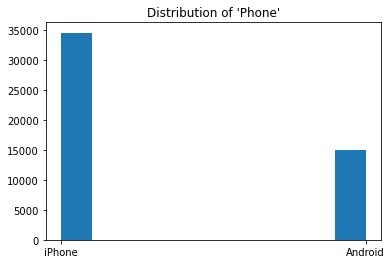

In [31]:
plt.hist(ultimate_data_df[np.logical_not(ultimate_data_df['phone'].isnull())]['phone'])
plt.title("Distribution of 'Phone'")
plt.show

"Phone" field has either iPhone or Android. It doesn't look like this field contributes much to the analysis/prediction. Still, let us try to fill the null values to keep the non null data consistent across the data.

Also this is a categorical field unlike the previous two fields and hence we cannot go with 'mean' approach. Therefore let us just use mostly used phone name to update the missing phone name. it looks like most of the drivers have 4.5 to 5 range ratings for avg_rating_by_driver as well. So we can go with similar mean approach. As per the above chart, 'iPhone' is the most used phone. Therefore, we can fill the null values with 'iPhone'

In [32]:
ultimate_data_df['phone'].fillna('iPhone', inplace=True)

ultimate_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    50000 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   50000 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    50000 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


Now the dataset looks clean with no nulls.

#### Handling Duplicates (if any)

In [33]:
# Remove duplicates
ultimate_data_df.drop_duplicates(keep = False, inplace = True)
ultimate_data_df.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,49984.000000,49984.000000,49984.000000,49984.000000,49984.000000,49984.000000,49984.000000
mean,2.278609,4.601480,1.074788,8.852369,60.933583,5.797693,4.778087
std,3.793222,0.565039,0.222368,19.961377,37.074952,5.707863,0.445807
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.500000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.700000,1.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000


In [34]:
print('Range of signup_date',find_range(ultimate_data_df['signup_date']))
print('Range of last_trip_date',find_range(ultimate_data_df['last_trip_date']))

Range of signup_date ('2014-01-01', '2014-01-31')
Range of last_trip_date ('2014-01-01', '2014-07-01')


1) The sign up date data shows that all the customers in the dataset got signed up in the month of Jan 2014.
2) The last trip date data shows that the last trip date was on July-01-2014.
3) Also, it has been said in part 3 question that the customers who signed up in the last 30 days should be considered as 'Retained'

Therefore, the customers who signed up on or after June-01-2014 would be considered as 'Retained'. 

In [35]:
# As we would be using these two date fields for our data handling/filtering, let us convert the signup and 
# last trip date fileds to Datetime format from string format. 

ultimate_data_df['signup_date'] = pd.to_datetime(ultimate_data_df['signup_date'])
ultimate_data_df['last_trip_date'] = pd.to_datetime(ultimate_data_df['last_trip_date'])

In [36]:
# Feature Engineer 'Retained' field based on 'Made trip in last 30 days' which will be our target field to predict.

ultimate_data_df['retained'] = ultimate_data_df['last_trip_date'] >= (max(ultimate_data_df['last_trip_date']) \
                                                                      -  pd.to_timedelta(30, unit='d'))
ultimate_data_df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,True
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,False
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,False
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,True
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,False


#### Outlier Analysis

In [37]:
#Let us look if there is any presence of outliers in the given dataset on the numerical columns.

numerical_features = ['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver', 
                      'avg_surge', 'surge_pct', 'trips_in_first_30_days', 'weekday_pct']

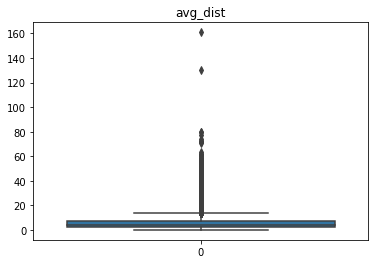

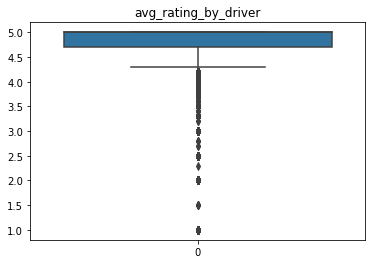

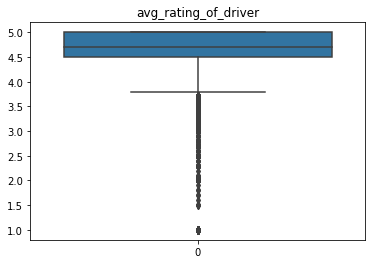

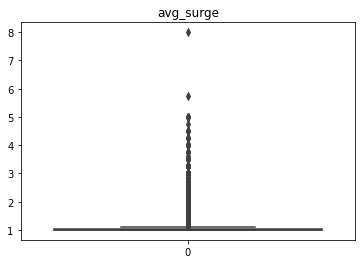

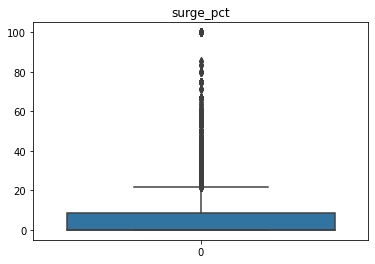

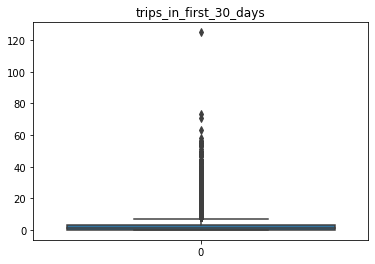

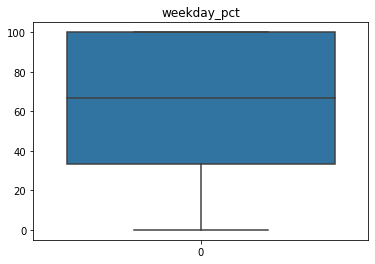

In [38]:
# We can plot box-plots on the numerical features as boxplot serves the best in identifying the outliers

for num_feature in numerical_features:
    sns.boxplot(data=ultimate_data_df[num_feature])
    plt.title(num_feature)
    plt.show();

It could be seen that the outliers are present in almost all the numerical columns except one. We can remove the records with outliers based its respective standard deviation

In [39]:
# Remove the records with numerical features that have figures more than 2 standard deviations from its respecive mean

#Note: Chose 3 standard deviations after trying with 1, 2, 3, 4.
#Std: 1 -> removes many records, 2 -> removes many data, 3-> removes less data with less outliers, 4->still more outliers

ultimate_data_df = ultimate_data_df[np.abs(ultimate_data_df['avg_dist']-ultimate_data_df['avg_dist'].mean())<=(3*ultimate_data_df['avg_dist'].std())]
ultimate_data_df = ultimate_data_df[np.abs(ultimate_data_df['avg_rating_by_driver']-ultimate_data_df['avg_rating_by_driver'].mean())<=(3*ultimate_data_df['avg_rating_by_driver'].std())]
ultimate_data_df = ultimate_data_df[np.abs(ultimate_data_df['avg_rating_of_driver']-ultimate_data_df['avg_rating_of_driver'].mean())<=(3*ultimate_data_df['avg_rating_of_driver'].std())]
ultimate_data_df = ultimate_data_df[np.abs(ultimate_data_df['avg_surge']-ultimate_data_df['avg_surge'].mean())<=(3*ultimate_data_df['avg_surge'].std())]
ultimate_data_df = ultimate_data_df[np.abs(ultimate_data_df['surge_pct']-ultimate_data_df['surge_pct'].mean())<=(3*ultimate_data_df['surge_pct'].std())]
ultimate_data_df = ultimate_data_df[np.abs(ultimate_data_df['trips_in_first_30_days']-ultimate_data_df['trips_in_first_30_days'].mean())<=(3*ultimate_data_df['trips_in_first_30_days'].std())]
ultimate_data_df.reset_index(drop=True, inplace=True)

In [40]:
ultimate_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44650 entries, 0 to 44649
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    44650 non-null  object        
 1   trips_in_first_30_days  44650 non-null  int64         
 2   signup_date             44650 non-null  datetime64[ns]
 3   avg_rating_of_driver    44650 non-null  float64       
 4   avg_surge               44650 non-null  float64       
 5   last_trip_date          44650 non-null  datetime64[ns]
 6   phone                   44650 non-null  object        
 7   surge_pct               44650 non-null  float64       
 8   ultimate_black_user     44650 non-null  bool          
 9   weekday_pct             44650 non-null  float64       
 10  avg_dist                44650 non-null  float64       
 11  avg_rating_by_driver    44650 non-null  float64       
 12  retained                44650 non-null  bool  

#### Cleaning categorical features

In [41]:
categorical_features = ['city', 'phone', 'ultimate_black_user']

def find_unique(col):
    return col.unique()

for col in categorical_features:
    print(f'{col}: {find_unique(ultimate_data_df[col])}')

city: ["King's Landing" 'Astapor' 'Winterfell']
phone: ['iPhone' 'Android']
ultimate_black_user: [ True False]


There is no cleaning required on categorical features as such, as the unique data is clean and has no typos or missing values.

#### Feature selection

Let us analyze which features serve the lot by constructing a correlation matrix

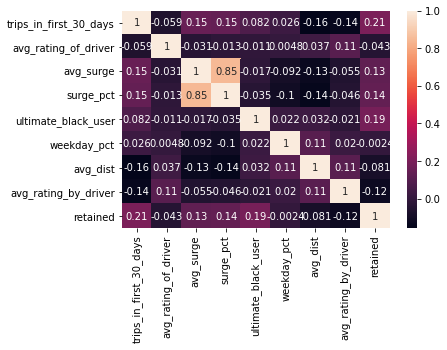

In [42]:
corr_matrix = ultimate_data_df.corr()
sns.heatmap(corr_matrix, annot=True)
plt.show()

1) We do see there are many negative correlations
2) In the positive correlations, there are many features with less than 50% correlation.
3) So it is viable to select the features at least with 50% correlation

In [43]:
# Convert boolean columns to integer (for numerical input to machine learning model)
ultimate_data_df['ultimate_black_user']=ultimate_data_df['ultimate_black_user'].astype(int)
ultimate_data_df['retained']=ultimate_data_df['retained'].astype(int) 

# Convert signup_date to integer (as the signup month and year are same across all customers)
ultimate_data_df['signup_day_nbr'] = ultimate_data_df['signup_date'].apply(lambda x: int(x.strftime('%Y-%m-%d')[8:]))


In [44]:
ultimate_data_df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained,signup_day_nbr
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,1,46.2,3.67,5.0,1,25
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,0,50.0,8.26,5.0,0,29
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,0,100.0,0.77,5.0,0,6
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,1,80.0,2.36,4.9,1,10
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,0,82.4,3.13,4.9,0,27


In [45]:
ultimate_data_df = pd.get_dummies(ultimate_data_df,columns=['city','phone'])

In [46]:
# Let us drop signup_date as signup day number has been derived as integer field and drop last_trip_date
# as 'retained' field has been derived.

ultimate_data_df.drop(['last_trip_date','signup_date'],inplace=True,axis=1)

##### Let us split the dataset into x features and y target

In [47]:
retain_df = ultimate_data_df['retained']
ultimate_data_df.drop(['retained'],inplace=True,axis=1)

#### Split train and test for model training

In [48]:
X_train, X_test, y_train, y_test = train_test_split(ultimate_data_df, retain_df, test_size=0.30,random_state=0)

#### Model Training

In [49]:
rf_classifier = RandomForestClassifier(min_samples_leaf=1, n_estimators=500, max_features='log2',criterion='gini',\
                          min_samples_split=8, max_depth=10)

rf_classifier.fit(X_train,y_train)

RandomForestClassifier(max_depth=10, max_features='log2', min_samples_split=8,
                       n_estimators=500)

##### Prediction Probability

In [50]:
y_predict = rf_classifier.predict_proba(X_test)[:, 1]

##### ROC Curve calculation

In [51]:
fpr, tpr, _ = roc_curve(y_test, y_predict)
roc_auc = auc(fpr, tpr)

#### ROC Curve Plot

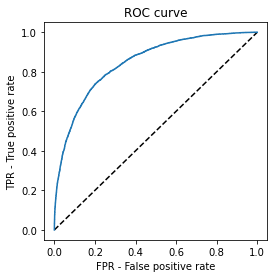

In [52]:
plt.figure(figsize=(4,4))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='RF')
                    
plt.xlabel('FPR - False positive rate')
plt.ylabel('TPR - True positive rate')
plt.title('ROC curve')

plt.show()

#### Accuracy Score

In [53]:
accuracy = accuracy_score(y_test, y_predict.round(), normalize=True)
print(f'Accuracy score: {round(accuracy,3)}')

Accuracy score: 0.776
